### Lesson06. Metric Learning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Activation, Dense, Conv2D, Flatten, MaxPool2D, AveragePooling2D, Dropout, Reshape
from tensorflow.keras.losses import categorical_crossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from sklearn.manifold import TSNE

import tensorflow_datasets as tfds

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Загрузим датасет LFW
train, info = tfds.load(
    'lfw',
    split=['train'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [4]:
train = train[0]

In [5]:
# Датасет скачан. Посмотрим, что там..

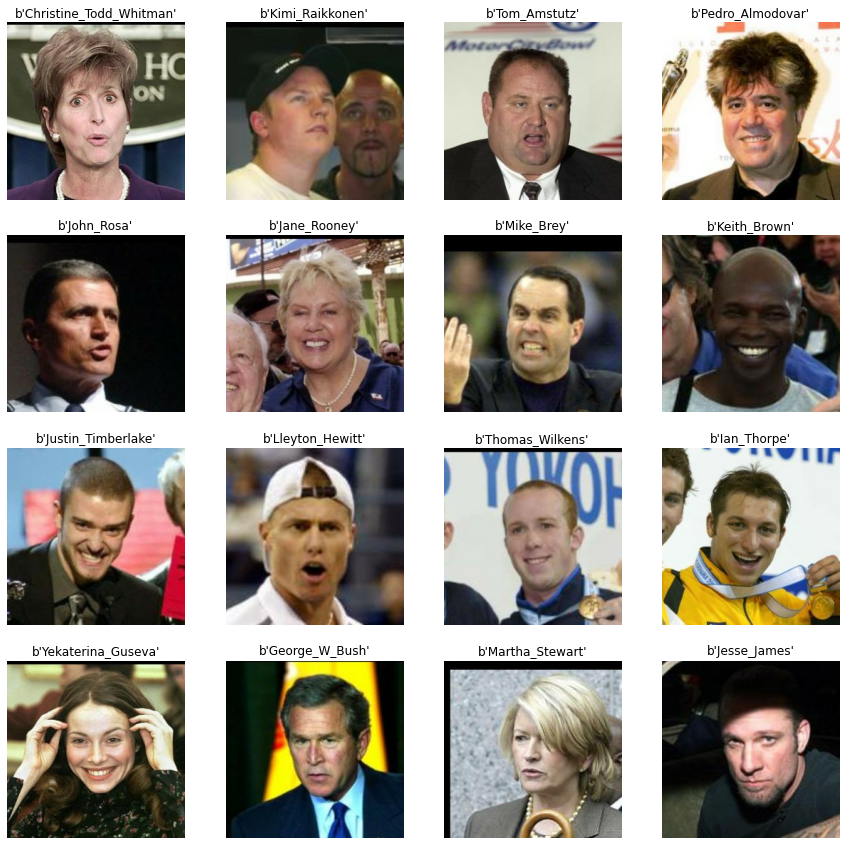

In [6]:
plt.figure(figsize=(15, 15))
for i, (label, image) in enumerate(train.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(label.numpy())
    plt.axis("off")

In [7]:
# Всего примеров:
len(train)

13233

In [8]:
# 13233 - нечетное значение... для contrastive loss это будет проблема на последнем батче.

In [9]:
train = train.take(13232)

In [10]:
# Сколько у нас уникальных классов интересно?
labels = []
for i, (label, _) in enumerate(train):
    labels.append(label.numpy())

In [11]:
labels = list(set(labels))

In [12]:
len(labels)

5749

In [13]:
# Вобщем там 5749 человек, на 13233 примера. То-есть мы тренируемся на почти 6К кластеров..

In [14]:
# Возьмем наверное какую-нибудь предобученную сеть, может это даст нам некоторую фору..
# Она уже будет изначально уметь "разбирать" картинки на фичи, есть мысль, что это позволит
# Быстрее начать получать годные эмбеддинги

In [15]:
iter(train).next()[1].shape

TensorShape([250, 250, 3])

In [16]:
vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(250, 250, 3)
)

vgg.trainable = True

In [17]:
# Фризим батч-норм параметры (если они там есть)
for layer in vgg.layers:
    if 'batch_normalization' in layer.name:
        layer.trainable = False

In [18]:
# Модел.. 
def build_model(embedding_size=256, training=True):
    inputs = tf.keras.Input(shape=(250, 250, 3))
    x = vgg(inputs, training=training)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    outputs = tf.keras.layers.Dense(embedding_size, activation=None)(x)
    model = tf.keras.Model(inputs, outputs)
    return model

In [19]:
model = build_model()

In [20]:
# Готовим и разбиваем на батчи и эпохи датасет
def normalize_img(label, image):
    return tf.cast(image, tf.float32) / 255., label

In [21]:
train_ds = train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.repeat(4)
train_ds = train_ds.shuffle(len(train))
train_ds = train_ds.batch(32)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
MARGIN = 10.0

def contrastive_loss(embeddings, labels):
    batch_size = embeddings.shape[0]
    embeddings1 = embeddings[:batch_size//2, :]
    embeddings2 = embeddings[batch_size//2:, :]
    labels1 = labels[:batch_size//2]
    labels2 = labels[batch_size//2:]
    
    d2 = tf.reduce_sum(tf.square(embeddings1 - embeddings2), axis=1)
    d = tf.sqrt(d2)
    z = tf.cast((labels1 == labels2), tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

In [23]:
# Гоняем предобученную сеть в режиме полной тренировки - соответственно lr очень маленький нужен
optimizer = tf.keras.optimizers.Adam(0.0001)

In [24]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward pass
    with tf.GradientTape() as tape:
        embeddings = model(images)
        loss_value = contrastive_loss(embeddings, labels)
        
    # Backpropogation
    gradients = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(gradients, model.variables))
    
    if iteration % 20 == 0:
        print(f'{iteration} Loss: {loss_value.numpy()}')

0 Loss: 23.92770767211914
20 Loss: 0.0
40 Loss: 0.0
60 Loss: 0.10592219233512878
80 Loss: 0.0
100 Loss: 1.1235871315002441
120 Loss: 0.27297306060791016
140 Loss: 0.0
160 Loss: 0.0
180 Loss: 0.1452513337135315
200 Loss: 0.0
220 Loss: 0.0
240 Loss: 0.0
260 Loss: 0.8436856269836426
280 Loss: 0.0
300 Loss: 0.08080580085515976
320 Loss: 0.0517229363322258
340 Loss: 10.977299690246582
360 Loss: 0.0
380 Loss: 0.0
400 Loss: 0.0
420 Loss: 0.0
440 Loss: 0.0
460 Loss: 0.0
480 Loss: 0.7275503277778625
500 Loss: 0.0
520 Loss: 0.0
540 Loss: 0.11921742558479309
560 Loss: 0.0
580 Loss: 0.0
600 Loss: 0.05520377308130264
620 Loss: 0.0
640 Loss: 0.0
660 Loss: 0.0
680 Loss: 0.30038702487945557
700 Loss: 0.0
720 Loss: 0.0
740 Loss: 0.0
760 Loss: 0.0
780 Loss: 0.0
800 Loss: 0.0
820 Loss: 0.0
840 Loss: 326.5483093261719
860 Loss: 0.002158545656129718
880 Loss: 0.0
900 Loss: 0.0
920 Loss: 0.36145076155662537
940 Loss: 0.0
960 Loss: 0.0
980 Loss: 0.0
1000 Loss: 0.0
1020 Loss: 0.0
1040 Loss: 0.0
1060 Loss: 0.0

In [25]:
# Долго не мог сообразить, в чем же тут дело. Не уверен, что сейчас правильно интерпретирую, 
# Но гипотеза такая - поскольку количество классов (6К) близко к общему количеству объектов (13К), 
# В большинстве батчей у нас ситуация - все полностью уникальны, и должны быть разнесены далеко
# В изначально натренированной сети видимо исходные веса сами по себе дают далекие вектора
# Поэтому когда в батче нет ни одного повторения класса - лосс = 0.. 
# В тех же батчах, где по случайности далекие объекты получили близкие вектора эмбеддингов - 
# Либо так повезло, что там попали объекты из одного класса - мы имеем какой-то ненулевой лосс
# Вот в эти моменты видимо и происходит обучение.
# Вообще - непонятно, как на таком датасете предполагается учить такую сеть..
# Практически то-же самое, что взять вообще все картинки из разных классов. И учить их быть
# далекими друг от друга. О какой кластеризации тут может вообще идти речь? :))

# Другое дело какой-нибудь MNIST - где 10 классов на 60К объектов.. Там в каждом батче
# Постоянно встречаются объекты одного класса, и объекты разных.. Есть что кластеризрвать )

In [26]:
model.save('saved_model/siam')

INFO:tensorflow:Assets written to: saved_model/siam/assets


INFO:tensorflow:Assets written to: saved_model/siam/assets


In [24]:
# Еще один прогон сделаем (почему-то происходит какая-то утечка памяти во время тренировки)
# Занятая память растет почти линейно.. к концу 4 эпохи под 60Гб оперативы занято... 
# У меня только 64Гб в системе. Вариант - тренировать 4 эпохи, сохранять веса, потом рестарт 
# Юпитера, и еще 4 эпохи )) Даж не знаю, в чем тут может крыться причина. 
# Вроде все хрестоматийно сделано....
model = tf.keras.models.load_model('saved_model/siam')

In [25]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward pass
    with tf.GradientTape() as tape:
        embeddings = model(images)
        loss_value = contrastive_loss(embeddings, labels)
        
    # Backpropogation
    gradients = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(gradients, model.variables))
    
    if iteration % 20 == 0:
        print(f'{iteration} Loss: {loss_value.numpy()}')

0 Loss: 0.00010037208267021924
20 Loss: 1.6301103830337524
40 Loss: 108.6272201538086
60 Loss: 0.0
80 Loss: 0.980168879032135
100 Loss: 1.4685920476913452
120 Loss: 1.9138133525848389
140 Loss: 0.0
160 Loss: 8.08716106414795
180 Loss: 0.0
200 Loss: 0.0
220 Loss: 0.0
240 Loss: 0.0
260 Loss: 0.0
280 Loss: 0.0
300 Loss: 0.0
320 Loss: 0.0
340 Loss: 0.0
360 Loss: 68.74879455566406
380 Loss: 0.0
400 Loss: 0.0
420 Loss: 4.478086471557617
440 Loss: 0.0
460 Loss: 0.0
480 Loss: 0.14244632422924042
500 Loss: 0.0
520 Loss: 0.0
540 Loss: 17.629230499267578
560 Loss: 0.0
580 Loss: 0.0
600 Loss: 0.0
620 Loss: 1.5568888187408447
640 Loss: 0.04995747655630112
660 Loss: 0.9183663129806519
680 Loss: 0.11947207897901535
700 Loss: 1.6923831701278687
720 Loss: 0.0
740 Loss: 4.030389785766602
760 Loss: 0.5528372526168823
780 Loss: 0.0
800 Loss: 2.0675010681152344
820 Loss: 0.0
840 Loss: 0.0
860 Loss: 0.0
880 Loss: 0.3350064754486084
900 Loss: 0.15845277905464172
920 Loss: 0.09098095446825027
940 Loss: 1.5656

In [26]:
model.save('saved_model/siam')

INFO:tensorflow:Assets written to: saved_model/siam/assets


INFO:tensorflow:Assets written to: saved_model/siam/assets


In [24]:
model = tf.keras.models.load_model('saved_model/siam')

In [45]:
# Переведем строковые лейблы в индексы
labels = []
for i, (label, _) in enumerate(train):
    labels.append(label.numpy())
unique = list(set(labels))

In [46]:
label_to_index = {}
for index, label in enumerate(unique):
    label_to_index[label] = index

In [35]:
test_batch = iter(train_ds).next()

In [38]:
test_batch[0].numpy().shape

(32, 250, 250, 3)

In [41]:
test_x_flat = test_batch[0].numpy().reshape(-1, 250*250*3)
test_x_flat.shape

(32, 187500)

In [74]:
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat)

labels_for_viz = test_batch[1].numpy()
indices = []
for label in labels_for_viz:
    indices.append(label_to_index[label])

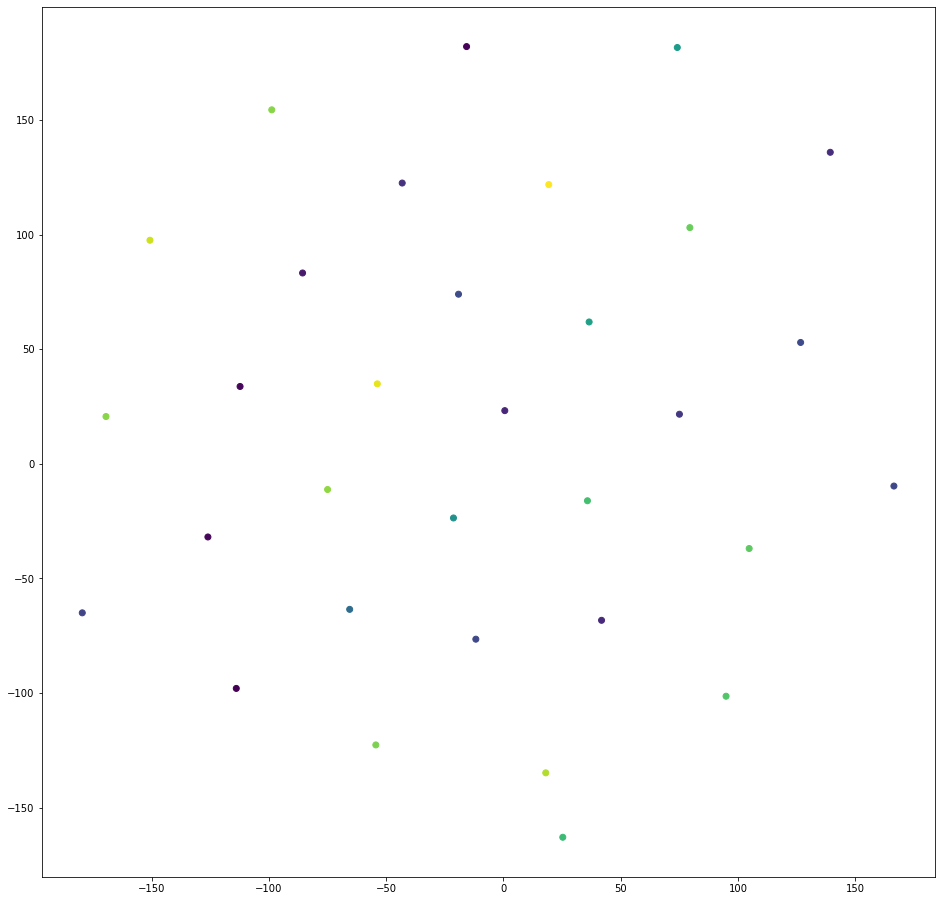

In [75]:
plt.figure(figsize=(16, 16))
plt.scatter(test_x_2D[:, 0], test_x_2D[:, 1], c=indices)

In [76]:
# Это фейковые эмбеддинги построенные путем конкатенации знаяений каналов фотографий... 

In [41]:
# 32 примера маааало... Хотелось бы наверное побольше попробовапть отобразить...
train_ds = train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(1024)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [42]:
test_batch = iter(train_ds).next()
test_x_flat = test_batch[0].numpy().reshape(-1, 250*250*3)
test_x_flat.shape

(1024, 187500)

In [43]:
test_x_2D = TSNE(n_components=2).fit_transform(test_x_flat)

labels_for_viz = test_batch[1].numpy()
indices = []
for label in labels_for_viz:
    indices.append(label_to_index[label])

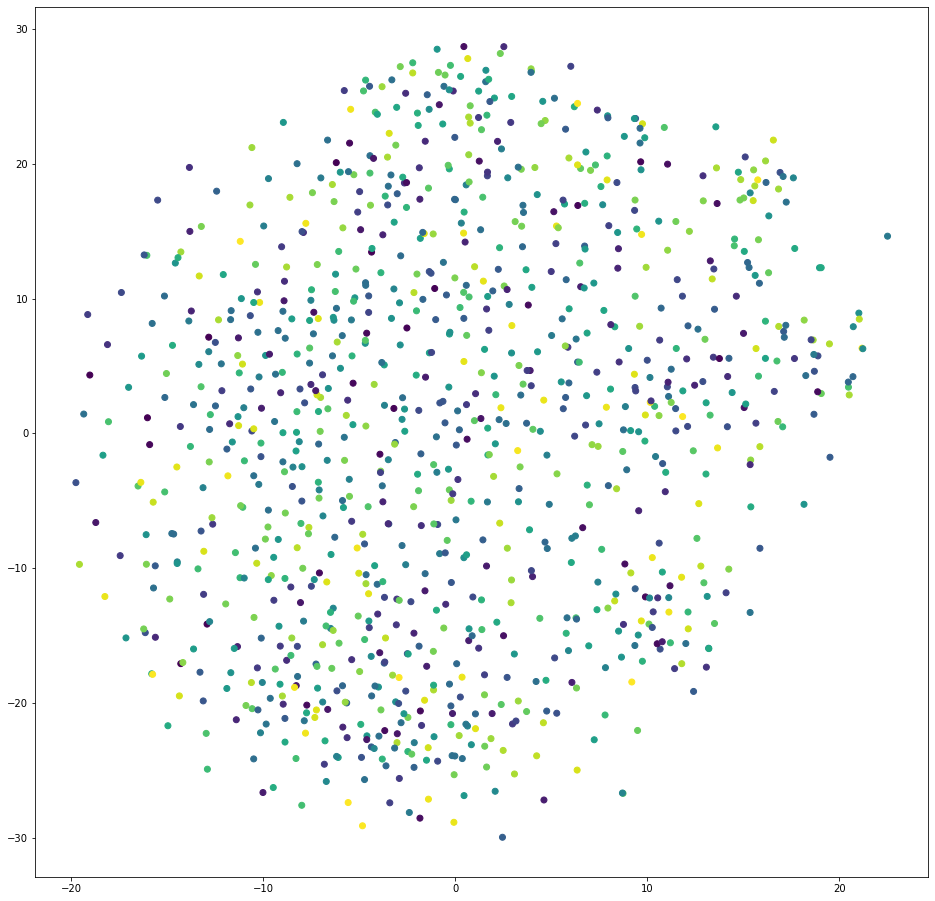

In [44]:
plt.figure(figsize=(16, 16))
plt.scatter(test_x_2D[:, 0], test_x_2D[:, 1], c=indices)

In [38]:
# Честно говоря - ничего тут не понять. Здесь около тысячи разных классов - 
# как их по цветам на-глаз различать? )

In [39]:
# Но - попробуем прогнать через модель все-таки

In [25]:
# Батч из тысячи фоток в GPU не поместится.. 
train_ds = train.take(1024).map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.batch(32)
train_ds = train_ds.cache()
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)

In [26]:
embeddings = []
for batch in train_ds:
    embeddings.append(model(batch[0]))

In [30]:
len(embeddings)

32

In [32]:
# 32 * 32 = 1024
# Склеим тензоры по батч измерению...
all_embs = tf.concat(embeddings, axis=0)

In [33]:
all_embs.shape

TensorShape([1024, 256])

In [34]:
# Окей, это наши 256-мерные эмбеддинги для 1024 примеров 
# Надо еще таргеты сконкатенировать также

In [40]:
labels = []
for batch in train_ds:
    labels.append(batch[1])

In [41]:
all_labels = tf.concat(labels, axis=0)

In [42]:
all_labels

<tf.Tensor: shape=(1024,), dtype=string, numpy=
array([b'George_W_Bush', b'Tim_Henman', b'Pieter_Bouw', ...,
       b'Nathan_Lane', b'Garry_Kasparov', b'Mikhail_Youzhny'],
      dtype=object)>

In [43]:
# Окей, приступаем к визу.. 

In [49]:
test_x_2D = TSNE(n_components=2).fit_transform(all_embs)

indices = []
for label in all_labels.numpy():
    indices.append(label_to_index[label])

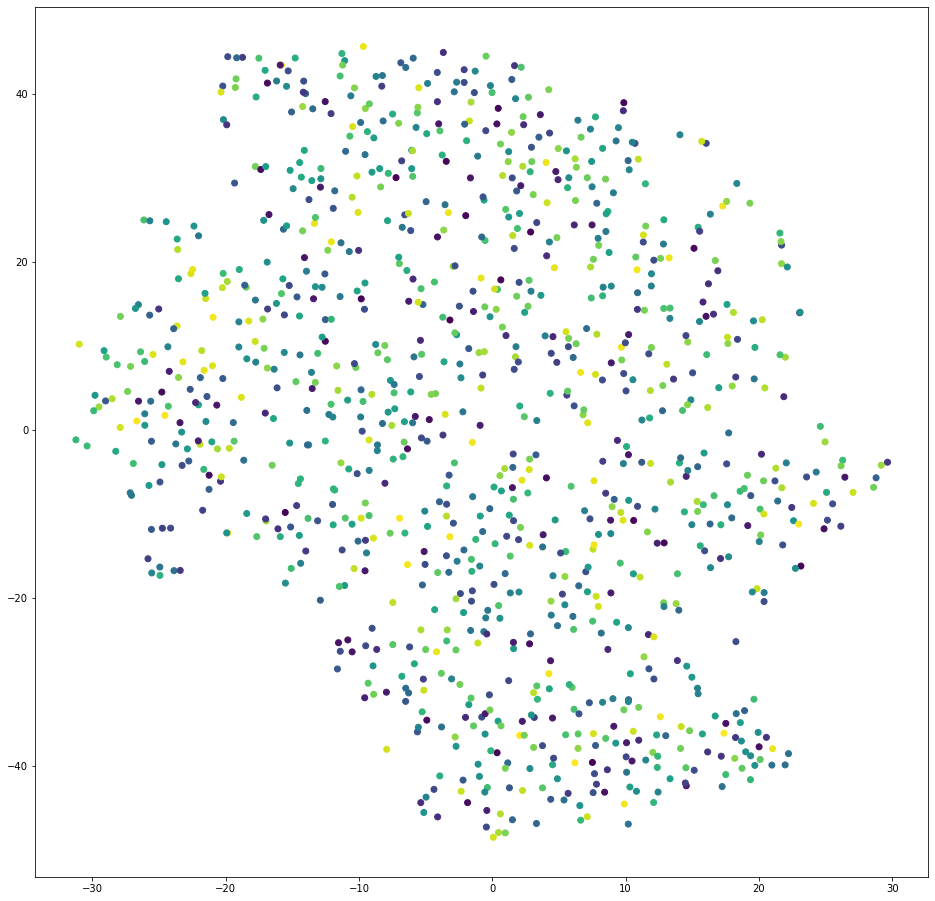

In [50]:
plt.figure(figsize=(16, 16))
plt.scatter(test_x_2D[:, 0], test_x_2D[:, 1], c=indices)

In [52]:
# Эммм... ну вот.. картинка явно другая :)))
# Никакой идеи, как понять, кто-тот одинаковые классы а кто разные - нет :)
# Вобщем вопрос открытый, как тренировать эмбеддинги на датасете, где практически все объекты 
# Из разных классов.. P.S. Возможно я жестко туплю просто )